In [8]:

import os
import mlflow
import pandas as pd
import psycopg
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, log_loss
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from autofeat import AutoFeatClassifier


os.environ["DB_DESTINATION_HOST"] = os.getenv("DB_DESTINATION_HOST")
os.environ["DB_DESTINATION_PORT"] = os.getenv("DB_DESTINATION_PORT")
os.environ["DB_DESTINATION_NAME"] = os.getenv("DB_DESTINATION_NAME")
os.environ["DB_DESTINATION_USER"] = os.getenv("DB_DESTINATION_USER")
os.environ["DB_DESTINATION_PASSWORD"] = os.getenv("DB_DESTINATION_PASSWORD")

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

# определяем глобальные переменные
# поднимаем MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000


registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)

/home/mle-user/.local/lib/python3.10/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [9]:
# название тестового эксперимента и запуска (run) внутри него
EXPERIMENT_NAME = "test_connection_experiment_vadim_shakula"
RUN_NAME = "baseline_logreg_v1"
REGISTRY_MODEL_NAME = "churn_model_vadimshakula"
FS_ASSETS = "fs_assets" 

In [10]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.environ["DB_DESTINATION_HOST"], 
    "port": os.environ["DB_DESTINATION_PORT"],
    "dbname": os.environ["DB_DESTINATION_NAME"],
    "user": os.environ["DB_DESTINATION_USER"],
    "password": os.environ["DB_DESTINATION_PASSWORD"],
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

In [11]:
# определим название таблицы, в которой хранятся наши данные.
TABLE_NAME = "clean_users_churn"

# эта конструкция создаёт контекстное управление для соединения с базой данных 
# оператор with гарантирует, что соединение будет корректно закрыто после выполнения всех операций 
# закрыто оно будет даже в случае ошибки, чтобы не допустить "утечку памяти"
with psycopg.connect(**connection) as conn:

# создаёт объект курсора для выполнения запросов к базе данных
# с помощью метода execute() выполняется SQL-запрос для выборки данных из таблицы TABLE_NAME
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
                
                # извлекаем все строки, полученные в результате выполнения запроса
        data = cur.fetchall()

                # получает список имён столбцов из объекта курсора
        columns = [col[0] for col in cur.description]

# создаёт объект DataFrame из полученных данных и имён столбцов. 
# это позволяет удобно работать с данными в Python, используя библиотеку Pandas.
df = pd.DataFrame(data, columns=columns)

In [12]:
df

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,1,7795-CFOCW,2016-05-01,2019-11-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,...,Yes,Yes,No,No,Male,0,No,No,No,0
1,2,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,...,No,No,No,No,Female,0,No,No,No,1
2,3,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,Fiber optic,...,Yes,No,Yes,Yes,Female,0,No,No,Yes,1
3,4,1452-KIOVK,2018-04-01,2019-11-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Fiber optic,...,No,No,Yes,No,Male,0,No,Yes,Yes,0
4,5,6713-OKOMC,2019-04-01,2019-11-01,Month-to-month,No,Mailed check,29.75,301.90,DSL,...,No,No,No,No,Female,0,No,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7014,7015,0550-DCXLH,2019-01-01,2019-11-01,Month-to-month,No,Mailed check,73.35,931.55,DSL,...,No,Yes,Yes,Yes,Male,0,No,No,No,0
7015,7016,9281-CEDRU,2014-06-01,2019-11-01,Two year,No,Bank transfer (automatic),64.10,4326.25,DSL,...,No,Yes,Yes,No,Female,0,Yes,No,No,0
7016,7017,2235-DWLJU,2019-08-01,2019-11-01,Month-to-month,Yes,Electronic check,44.40,263.05,DSL,...,No,No,Yes,Yes,Female,1,No,No,No,0
7017,7018,0871-OPBXW,2019-12-01,2019-11-01,Month-to-month,Yes,Mailed check,20.05,39.25,Fiber optic,...,No,No,No,No,Female,0,No,No,No,0


In [13]:
split_column = "begin_date"
test_size = 0.2

cat_features = [
    'paperless_billing',
    'payment_method',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines',
]
num_features = ["monthly_charges", "total_charges"]
target = ['target']

features = cat_features + num_features

df = df.sort_values(by=[split_column])

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[target],
    test_size=test_size,
    shuffle=False,
) 

transformations = ('1/', 'log', 'abs', 'sqrt')

afc = AutoFeatClassifier(categorical_cols=cat_features, transformations=transformations, feateng_steps=1, n_jobs=-1)

X_train_features = afc.fit_transform(X_train,  y_train)
X_test_features = afc.transform(X_test)

/home/mle-user/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
# ================== Полный рабочий блок для SFS/SBS с кэшем ==================
# Импорты и базовые настройки
import os
import pickle
from pathlib import Path
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# --- управляем кэшированием и путями ---
FORCE_REFIT = bool(int(os.getenv("FORCE_REFIT", "0")))  # 0/1 из окружения; по умолчанию False
CACHE_DIR = Path(os.getenv("SELECTOR_CACHE_DIR", "./selector_cache"))
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# -------- вспомогалки ----------
def _hash_config(d: dict) -> str:
    import hashlib
    return hashlib.md5(repr(sorted(d.items())).encode("utf-8")).hexdigest()[:12]

def _selector_signature(sel) -> dict:
    sig = {}
    for attr in ["k_features", "forward", "floating", "scoring", "cv", "n_jobs"]:
        if hasattr(sel, attr):
            sig[attr] = getattr(sel, attr)
    est = getattr(sel, "estimator", None)
    if est is not None:
        sig["estimator_cls"] = est.__class__.__name__
        try:
            sig["estimator_params"] = est.get_params()
        except Exception:
            sig["estimator_params"] = str(est)
    return sig

def _data_signature(X, y) -> dict:
    cols = getattr(X, "columns", None)
    if cols is not None:
        cols = tuple(map(str, cols))
    xshape = getattr(X, "shape", None)
    yshape = getattr(y, "shape", None)
    return {"X_cols": cols, "X_shape": xshape, "y_shape": yshape}

def cached_fit_selector(selector, X, y, name: str, force_refit: bool=False):
    cfg = {"name": name}
    cfg.update(_selector_signature(selector))
    cfg.update(_data_signature(X, y))
    key = _hash_config(cfg)
    path = CACHE_DIR / f"{name}_{key}.pkl"
    if path.exists() and not force_refit:
        with open(path, "rb") as f:
            return pickle.load(f)
    fitted = selector.fit(X, y)
    with open(path, "wb") as f:
        pickle.dump(fitted, f)
    return fitted

# -------- подхватываем твои данные из предыдущей ячейки ----------
# Ожидается, что переменные X_train_features, X_test_features, y_train уже существуют.
X_tr = X_train_features
X_te = X_test_features
# делаем y одномерным (на случай, если это DataFrame со столбцом 'target')
y_tr = np.ravel(y_train.values if hasattr(y_train, "values") else y_train)

# --- имена признаков для вывода (если это не DataFrame — создадим f0, f1, ...) ---
if hasattr(X_tr, "columns"):
    feature_names = list(map(str, X_tr.columns))
else:
    feature_names = [f"f{i}" for i in range(X_tr.shape[1])]

# (опционально) ускоряем вычисления float32
try:
    if hasattr(X_tr, "astype"):
        X_tr = X_tr.astype(np.float32, copy=False)
        if X_te is not None and hasattr(X_te, "astype"):
            X_te = X_te.astype(np.float32, copy=False)
except Exception:
    pass

# --- безопасно определим k_features (не больше числа признаков и >=1) ---
n_features = X_tr.shape[1]
k_best = max(1, min(10, n_features))

# лёгкий RF для селекции (быстрее, чем глубокий лес)
selector_estimator = RandomForestClassifier(
    n_estimators=120,
    max_depth=8,
    min_samples_leaf=5,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42,
)

# более дешёвый CV
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- SFS (forward) ---
sfs = SFS(
    selector_estimator,
    k_features=k_best,
    forward=True,
    floating=False,      # floating существенно дороже; отключаем
    scoring="roc_auc",
    cv=cv3,
    n_jobs=-1,
    verbose=0,
)
sfs = cached_fit_selector(sfs, X_tr, y_tr, name="sfs", force_refit=FORCE_REFIT)

# --- SBS (backward) ---
sbs = SFS(
    selector_estimator,
    k_features=k_best,
    forward=False,
    floating=False,
    scoring="roc_auc",
    cv=cv3,
    n_jobs=-1,
    verbose=0,
)
sbs = cached_fit_selector(sbs, X_tr, y_tr, name="sbs", force_refit=FORCE_REFIT)

# --- извлекаем выбранные индексы/имена признаков
def _chosen_names(selector, all_names):
    idx = getattr(selector, "k_feature_idx_", None)
    if idx is None:
        # запасной вариант — попробуем k_feature_names_; если нет — вернём пустой кортеж
        names = getattr(selector, "k_feature_names_", ())
        return tuple(map(str, names)) if names else ()
    return tuple(all_names[i] for i in idx)

top_sfs = _chosen_names(sfs, feature_names)
top_sbs = _chosen_names(sbs, feature_names)

# --- трансформации обучающей/тестовой выборок
X_train_sfs = sfs.transform(X_tr)
X_train_sbs = sbs.transform(X_tr)
X_test_sfs  = sfs.transform(X_te) if X_te is not None else None
X_test_sbs  = sbs.transform(X_te) if X_te is not None else None

# --- вывод результатов
print(f"Число исходных признаков: {n_features}")
print(f"Выбираем k_features = {k_best}")

print("\nSequential Forward Selection (SFS)")
print("CV AUC:", getattr(sfs, "k_score_", None))
print("Top features:", top_sfs)

print("\nSequential Backward Selection (SBS)")
print("CV AUC:", getattr(sbs, "k_score_", None))
print("Top features:", top_sbs)
# ============================================================================== 


Число исходных признаков: 33
Выбираем k_features = 10

Sequential Forward Selection (SFS)
CV AUC: 0.8312825898911246
Top features: ('monthly_charges', 'total_charges', 'cat_paperless_billing_No', 'cat_payment_method_Electronic check', 'cat_internet_service_DSL', 'cat_online_backup_Yes', 'cat_tech_support_Yes', 'cat_streaming_tv_Yes', 'cat_streaming_movies_No', 'cat_gender_Female')

Sequential Backward Selection (SBS)
CV AUC: 0.8304064316214376
Top features: ('monthly_charges', 'total_charges', 'cat_paperless_billing_Yes', 'cat_payment_method_Electronic check', 'cat_internet_service_Fiber optic', 'cat_online_backup_No', 'cat_tech_support_No', 'cat_streaming_tv_Yes', 'cat_streaming_movies_Yes', 'cat_gender_Male')


In [23]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 

In [24]:
sbs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
33,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8187465311872947, 0.8311570994497823, 0.840...",0.830188,"(monthly_charges, total_charges, cat_paperless...",0.020191,0.008973,0.006345
32,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8200307390172054, 0.8285685445238291, 0.842...",0.83023,"(monthly_charges, total_charges, cat_paperless...",0.020439,0.009082,0.006422
31,"(0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.8189873201554028, 0.8294641879499604, 0.841...",0.830024,"(monthly_charges, total_charges, cat_paperless...",0.020811,0.009248,0.006539
30,"(0, 1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15...","[0.8201118558681638, 0.8292238099148668, 0.843...",0.830858,"(monthly_charges, total_charges, cat_paperless...",0.021405,0.009512,0.006726
29,"(0, 1, 2, 3, 6, 7, 8, 9, 11, 12, 13, 14, 15, 1...","[0.8201024633906844, 0.8286267142974459, 0.844...",0.831091,"(monthly_charges, total_charges, cat_paperless...",0.022794,0.010129,0.007162
28,"(0, 1, 2, 3, 6, 7, 8, 9, 11, 12, 13, 14, 15, 1...","[0.8201827263800539, 0.8301699241739893, 0.843...",0.831157,"(monthly_charges, total_charges, cat_paperless...",0.021129,0.009389,0.006639
27,"(0, 1, 2, 3, 6, 7, 8, 9, 11, 12, 13, 14, 15, 1...","[0.8193835119327157, 0.831414586241822, 0.8449...",0.831903,"(monthly_charges, total_charges, cat_paperless...",0.023464,0.010427,0.007373
26,"(0, 1, 2, 3, 6, 7, 8, 9, 11, 12, 13, 14, 15, 1...","[0.8182564146351876, 0.8315916618762148, 0.843...",0.831119,"(monthly_charges, total_charges, cat_paperless...",0.023212,0.010315,0.007294
25,"(0, 1, 2, 3, 6, 7, 8, 9, 11, 12, 13, 14, 16, 1...","[0.8199479144430688, 0.8314257069338371, 0.842...",0.831238,"(monthly_charges, total_charges, cat_paperless...",0.020574,0.009143,0.006465
24,"(0, 1, 2, 3, 6, 7, 8, 9, 11, 12, 13, 14, 16, 1...","[0.8203423984972036, 0.8314359721880047, 0.844...",0.832017,"(monthly_charges, total_charges, cat_paperless...",0.022005,0.009778,0.006914


In [25]:

os.mkdir(FS_ASSETS)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv") 

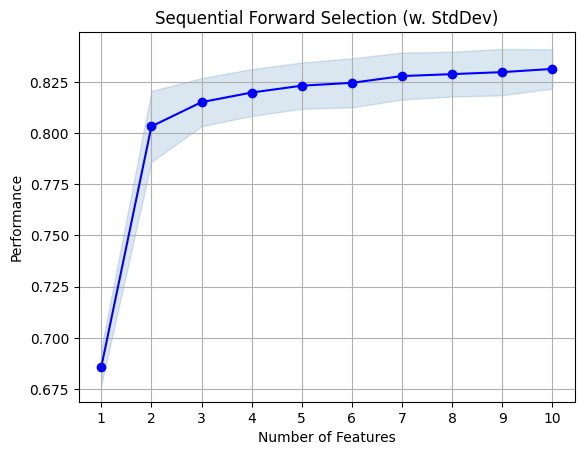

<Figure size 640x480 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt
#from mlxtend.plotting import plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sfs.png") 

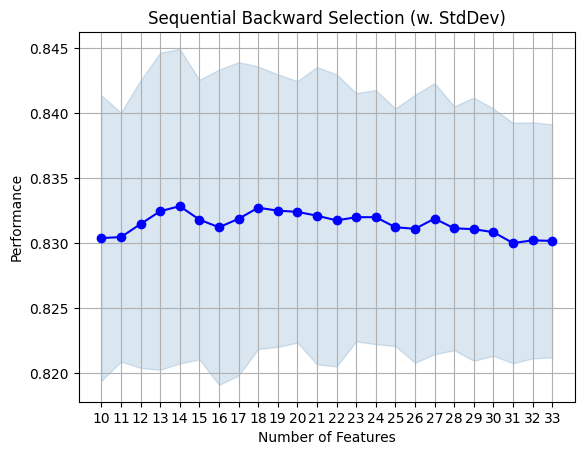

<Figure size 640x480 with 0 Axes>

In [27]:
fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sbs.png")

In [28]:
interc_features = list(set(top_sbs) & set(top_sfs))
union_features = list(set(top_sbs) | set(top_sfs))

In [29]:
interc_features

['monthly_charges',
 'cat_payment_method_Electronic check',
 'total_charges',
 'cat_streaming_tv_Yes']

In [30]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
   
    mlflow.log_artifacts(FS_ASSETS) 

2025-09-04 19:06:07,940 INFO: Found credentials in environment variables.


In [32]:
X_train_features_interc = X_train_features.loc[:,interc_features]
X_train_features_union = X_train_features.loc[:,union_features]
X_test_features_interc = X_test_features.loc[:,interc_features]
X_test_features_union = X_test_features.loc[:,union_features]

In [33]:
model_interc = CatBoostClassifier()
model_interc.fit(X_train_features_interc, y_train)
prediction_interc = model_interc.predict(X_test_features_interc)

Learning rate set to 0.021523
0:	learn: 0.6796213	total: 47.8ms	remaining: 47.8s
1:	learn: 0.6659390	total: 49.8ms	remaining: 24.8s
2:	learn: 0.6526196	total: 51.6ms	remaining: 17.1s
3:	learn: 0.6420769	total: 52.9ms	remaining: 13.2s
4:	learn: 0.6310940	total: 54.5ms	remaining: 10.8s
5:	learn: 0.6232063	total: 56.2ms	remaining: 9.3s
6:	learn: 0.6125522	total: 58.5ms	remaining: 8.3s
7:	learn: 0.6024681	total: 62.1ms	remaining: 7.7s
8:	learn: 0.5951775	total: 66.3ms	remaining: 7.3s
9:	learn: 0.5866026	total: 70.5ms	remaining: 6.98s
10:	learn: 0.5772869	total: 75.9ms	remaining: 6.82s
11:	learn: 0.5686835	total: 78.4ms	remaining: 6.46s
12:	learn: 0.5633687	total: 79.7ms	remaining: 6.05s
13:	learn: 0.5554722	total: 82ms	remaining: 5.78s
14:	learn: 0.5479926	total: 83.9ms	remaining: 5.51s
15:	learn: 0.5410063	total: 85.8ms	remaining: 5.28s
16:	learn: 0.5344438	total: 87.7ms	remaining: 5.07s
17:	learn: 0.5283486	total: 89.7ms	remaining: 4.89s
18:	learn: 0.5230702	total: 91.1ms	remaining: 4.7s

In [34]:
model_union = CatBoostClassifier()
model_union.fit(X_train_features_union, y_train)
prediction_union = model_union.predict(X_test_features_union)

Learning rate set to 0.021523
0:	learn: 0.6772118	total: 12.9ms	remaining: 12.9s
1:	learn: 0.6617214	total: 21.4ms	remaining: 10.7s
2:	learn: 0.6468446	total: 52.1ms	remaining: 17.3s
3:	learn: 0.6326372	total: 97.9ms	remaining: 24.4s
4:	learn: 0.6212872	total: 101ms	remaining: 20.1s
5:	learn: 0.6102343	total: 112ms	remaining: 18.6s
6:	learn: 0.5998310	total: 157ms	remaining: 22.3s
7:	learn: 0.5894485	total: 160ms	remaining: 19.8s
8:	learn: 0.5783411	total: 179ms	remaining: 19.7s
9:	learn: 0.5692647	total: 196ms	remaining: 19.4s
10:	learn: 0.5593693	total: 201ms	remaining: 18.1s
11:	learn: 0.5507310	total: 215ms	remaining: 17.7s
12:	learn: 0.5440474	total: 229ms	remaining: 17.4s
13:	learn: 0.5354185	total: 244ms	remaining: 17.2s
14:	learn: 0.5294083	total: 283ms	remaining: 18.6s
15:	learn: 0.5227462	total: 293ms	remaining: 18s
16:	learn: 0.5173000	total: 307ms	remaining: 17.8s
17:	learn: 0.5103889	total: 311ms	remaining: 17s
18:	learn: 0.5041126	total: 315ms	remaining: 16.3s
19:	learn: 

In [35]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, log_loss
# импортируйте необходимые вам модули
def make_metrics(y_test, prediction):
    metrics = {}

    # посчитайте метрики из модуля sklearn.metrics
    # err_1 — ошибка первого рода
    # err_2 — ошибка второго рода
    _, err1, err2, _ = confusion_matrix(y_test, prediction,normalize='all').ravel()
    #auc = roc_auc_score(y_test, probas)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    logloss = log_loss(y_test, prediction)

    # запишите значения метрик в словарь
    metrics["err1"] = err1
    metrics["err2"] = err2
    #metrics["auc"] = auc
    metrics["precision"] = precision
    metrics["recall"] = recall
    metrics["f1"] = f1
    metrics["logloss"] = logloss
    
    return metrics

metrics_interc = make_metrics(y_test, prediction_interc)
metrics_union = make_metrics(y_test, prediction_union)

In [36]:
pip_requirements = "requirements.txt"
signature_u = mlflow.models.infer_signature(X_train_features_union, prediction_union)
input_example_u = X_train_features_union[:10]
metadata =  {'model_type': 'churn_month'}

pip_requirements = "requirements.txt"
signature_i= mlflow.models.infer_signature(X_train_features_union, prediction_union)
input_example_i = X_train_features_union[:10]
metadata =  {'model_type': 'churn_month'}

artifact_path = "model"

In [37]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

if not experiment_id:
        experiment_id = mlflow.create_experiment(EXPERIMENT_NAME) # ваш код здесь

with mlflow.start_run(run_name='Union_sbs', experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id # ваш код здесь
    
    model_info = mlflow.catboost.log_model( 
			cb_model=model_union,
            pip_requirements=pip_requirements,
            signature=signature_u,
            input_example=input_example_u,
            metadata=metadata,
            #code_path=code_paths,
            await_registration_for=60,
            artifact_path=artifact_path,
            registered_model_name="churn_model_union_intersec")

    mlflow.log_metrics(metrics_union) 

    afc_info = mlflow.sklearn.log_model(afc, artifact_path=artifact_path) 
    
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
# получаем данные о запуске эксперимента по его уникальному идентификатору
run = mlflow.get_run(run_id) # ваш код здесь


# проверяем, что статус запуска эксперимента изменён на 'FINISHED'
# это утверждение (assert) можно использовать для автоматической проверки того, 
# что эксперимент был завершён успешно
assert (run.info.status =='FINISHED')# ваш код здесь

# удаляем файлы 'columns.txt' и 'users_churn.csv' из файловой системы,
# чтобы очистить рабочую среду после логирования артефактов
#os.remove('columns.txt') # ваш код здесь
#os.remove('users_churn.csv') # ваш код здесьcsv

Successfully registered model 'churn_model_union_intersec'.
2025/09/04 19:09:52 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_union_intersec, version 1
Created version '1' of model 'churn_model_union_intersec'.


In [38]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

if not experiment_id:
        experiment_id = mlflow.create_experiment(EXPERIMENT_NAME) # ваш код здесь

with mlflow.start_run(run_name='Intersec_sbs', experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id # ваш код здесь
    
    model_info = mlflow.catboost.log_model( 
			cb_model=model_interc,
            pip_requirements=pip_requirements,
            signature=signature_i,
            input_example=input_example_i,
            metadata=metadata,
            #code_path=code_paths,
            await_registration_for=60,
            artifact_path=artifact_path,
            registered_model_name="churn_model_union_intersec")

    mlflow.log_metrics(metrics_interc) 

    afc_info = mlflow.sklearn.log_model(afc, artifact_path=artifact_path) 
    
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
# получаем данные о запуске эксперимента по его уникальному идентификатору
run = mlflow.get_run(run_id) # ваш код здесь


# проверяем, что статус запуска эксперимента изменён на 'FINISHED'
# это утверждение (assert) можно использовать для автоматической проверки того, 
# что эксперимент был завершён успешно
assert (run.info.status =='FINISHED')# ваш код здесь

# удаляем файлы 'columns.txt' и 'users_churn.csv' из файловой системы,
# чтобы очистить рабочую среду после логирования артефактов
#os.remove('columns.txt') # ваш код здесь
#os.remove('users_churn.csv') # ваш код здесьcsv

Registered model 'churn_model_union_intersec' already exists. Creating a new version of this model...
2025/09/04 19:10:27 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_union_intersec, version 2
Created version '2' of model 'churn_model_union_intersec'.


In [48]:
client = mlflow.MlflowClient(tracking_uri=tracking_uri, registry_uri=registry_uri)


models = client.search_model_versions(
    filter_string=f"name = '{REGISTRY_MODEL_NAME}'"
)
print(f"Model info:\n {models}")

model_name_1 = models[-1].name
model_version_1 = models[-1].version
model_stage_1 = models[-1].current_stage

if len(models) >= 2:
    model_name_2 = models[-2].name
    model_version_2 = models[-2].version
    model_stage_2 = models[-2].current_stage
    print(f"Текущий stage модели 2: {model_stage_2}")
else:
    model_name_2 = model_version_2 = model_stage_2 = None
    print("Найдена только одна версия модели; шаг со второй версией будет пропущен.")

# поменяйте статус каждой модели
client.transition_model_version_stage(
    model_name_1, model_version_1, 'production', archive_existing_versions=True)
if model_version_2 is not None:
    client.transition_model_version_stage(
        model_name_2, model_version_2, 'Staging')

# переимнуйте модель в реестре
client.rename_registered_model(
    name = REGISTRY_MODEL_NAME, new_name = f'{REGISTRY_MODEL_NAME}_b2cc')

Model info:
 [<ModelVersion: aliases=[], creation_timestamp=1756651250126, current_stage='Production', description='', last_updated_timestamp=1757013827310, name='churn_model_vadimshakula', run_id='90e7f8d96c234294a6cd521d6d356331', run_link='', source='s3://s3-student-mle-20250802-8a8f1a1def-freetrack/5/90e7f8d96c234294a6cd521d6d356331/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>]
Найдена только одна версия модели; шаг со второй версией будет пропущен.


In [49]:
print(f"Текущий stage модели 1: {model_stage_1}")
print(f"Текущий stage модели 2: {model_stage_2}")

Текущий stage модели 1: Production
Текущий stage модели 2: None


In [ ]:
client = mlflow.MlflowClient(tracking_uri=tracking_uri, registry_uri=registry_uri)

experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
experiment_id

'5'

In [51]:
experiment_runs = mlflow.search_runs(
    experiment_ids=[experiment_id],
).sort_values(by="start_time", ascending=False) 
experiment_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.recall,metrics.logloss,metrics.f1,metrics.precision,...,metrics.tn,metrics.roc_auc,metrics.fp,metrics.fn,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.log-model.history,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.git.commit
0,a6827e0d1ddd41fa951cf36778d6ed39,5,FINISHED,s3://s3-student-mle-20250802-8a8f1a1def-freetr...,2025-09-04 19:10:26.829000+00:00,2025-09-04 19:10:30.888000+00:00,0.851632,13.503534,0.685783,0.574000,...,NaN,NaN,NaN,NaN,mle-user,LOCAL,"[{""run_id"": ""a6827e0d1ddd41fa951cf36778d6ed39""...",Intersec_sbs,/home/mle-user/.local/lib/python3.10/site-pack...,None
1,927da185dd3641b6b4f74c0b7586c635,5,FINISHED,s3://s3-student-mle-20250802-8a8f1a1def-freetr...,2025-09-04 19:09:50.787000+00:00,2025-09-04 19:09:57.726000+00:00,0.850148,13.246813,0.689531,0.579960,...,NaN,NaN,NaN,NaN,mle-user,LOCAL,"[{""run_id"": ""927da185dd3641b6b4f74c0b7586c635""...",Union_sbs,/home/mle-user/.local/lib/python3.10/site-pack...,None
2,4d02ea23b1dd4e5589bf13b185c1cebc,5,FINISHED,s3://s3-student-mle-20250802-8a8f1a1def-freetr...,2025-09-04 19:06:07.387000+00:00,2025-09-04 19:06:09.370000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,mle-user,LOCAL,None,baseline_logreg_v1_intersection_and_union,/home/mle-user/.local/lib/python3.10/site-pack...,None
3,5e2d9ccd929945f3bedf7a229c775ec6,5,FINISHED,s3://s3-student-mle-20250802-8a8f1a1def-freetr...,2025-09-01 17:06:52.429000+00:00,2025-09-01 17:06:56.260000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,mle-user,LOCAL,"[{""run_id"": ""5e2d9ccd929945f3bedf7a229c775ec6""...",preprocessing,/home/mle-user/.local/lib/python3.10/site-pack...,None
4,90e7f8d96c234294a6cd521d6d356331,5,FINISHED,s3://s3-student-mle-20250802-8a8f1a1def-freetr...,2025-08-31 14:40:49.391000+00:00,2025-08-31 14:40:50.142000+00:00,0.825737,0.155965,0.886331,0.956522,...,NaN,NaN,NaN,NaN,mle-user,LOCAL,"[{""run_id"": ""90e7f8d96c234294a6cd521d6d356331""...",baseline_logreg_v1,/home/mle-user/mle_projects/mle-mlflow/scripts...,3ebac88e3f89f12d84b40f9e5ad02409e2cb78c3
5,e7eb88055a5b4f69a8a5daf9e66a9a19,5,FINISHED,s3://s3-student-mle-20250802-8a8f1a1def-freetr...,2025-08-31 13:14:27.916000+00:00,2025-08-31 13:14:32.201000+00:00,0.825737,0.155965,0.886331,0.956522,...,1017.0,0.968762,14.0,65.0,mle-user,LOCAL,"[{""run_id"": ""e7eb88055a5b4f69a8a5daf9e66a9a19""...",baseline_logreg_v1,/home/mle-user/.local/lib/python3.10/site-pack...,None
6,f1e1582613944c79b32602456376c203,5,FAILED,s3://s3-student-mle-20250802-8a8f1a1def-freetr...,2025-08-31 13:12:24.439000+00:00,2025-08-31 13:12:25.316000+00:00,0.825737,0.155965,0.886331,0.956522,...,1017.0,0.968762,14.0,65.0,mle-user,LOCAL,None,baseline_logreg_v1,/home/mle-user/.local/lib/python3.10/site-pack...,None
7,6d9c640f1c694de29937ea8144a8671b,5,FINISHED,s3://s3-student-mle-20250802-8a8f1a1def-freetr...,2025-08-29 19:49:08.179000+00:00,2025-08-29 19:49:10.227000+00:00,0.825737,0.155965,0.886331,0.956522,...,NaN,NaN,NaN,NaN,mle-user,LOCAL,"[{""run_id"": ""6d9c640f1c694de29937ea8144a8671b""...",baseline_logreg_v1,/home/mle-user/mle_projects/mle-mlflow/scripts...,8707265a5da18b8d58f4ed23fdc9b8b80cbe2285
8,3d0537ce632148f8bcd6f2c3d8c17c71,5,FINISHED,s3://s3-student-mle-20250802-8a8f1a1def-freetr...,2025-08-29 19:07:08.402000+00:00,2025-08-29 19:07:09.311000+00:00,0.825737,0.155965,0.886331,0.956522,...,NaN,NaN,NaN,NaN,mle-user,LOCAL,"[{""run_id"": ""3d0537ce632148f8bcd6f2c3d8c17c71""...",baseline_logreg_v1,/home/mle-user/mle_projects/mle-mlflow/scripts...,8707265a5da18b8d58f4ed23fdc9b8b80cbe2285
9,412303638bff4d028afb329cfffbd2d3,5,FAILED,s3://s3-student-mle-20250802-8a8f1a1def-freetr...,2025-08-29 18:41:11.429000+00:00,2025-08-29 18:42:22.703000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,mle-user,LOCAL,None,baseline_logreg_v1,/home/mle-user/mle_projects/mle-mlflow/scripts...,8707265a5da18b8d58f4ed23fdc9b8b80cbe2285


In [52]:
print( '"'+ '","'.join([col for col in experiment_runs.columns if 'metric' in col])+'"')
runs = experiment_runs[[
	"run_id", "start_time", "metrics.precision","metrics.f1","metrics.logloss","metrics.recall","metrics.err1","metrics.err2"
	
]].dropna()
runs

"metrics.recall","metrics.logloss","metrics.f1","metrics.precision","metrics.err1","metrics.err2","metrics.err2_rate","metrics.auc","metrics.err1_rate","metrics.tp","metrics.tn","metrics.roc_auc","metrics.fp","metrics.fn"


,run_id,start_time,metrics.precision,metrics.f1,metrics.logloss,metrics.recall,metrics.err1,metrics.err2
0,a6827e0d1ddd41fa951cf36778d6ed39,2025-09-04 19:10:26.829000+00:00,0.574000,0.685783,13.503534,0.851632,0.303419,0.071225
1,927da185dd3641b6b4f74c0b7586c635,2025-09-04 19:09:50.787000+00:00,0.579960,0.689531,13.246813,0.850148,0.295584,0.071937
4,90e7f8d96c234294a6cd521d6d356331,2025-08-31 14:40:49.391000+00:00,0.956522,0.886331,0.155965,0.825737,14.000000,65.000000
7,6d9c640f1c694de29937ea8144a8671b,2025-08-29 19:49:08.179000+00:00,0.956522,0.886331,0.155965,0.825737,14.000000,65.000000
8,3d0537ce632148f8bcd6f2c3d8c17c71,2025-08-29 19:07:08.402000+00:00,0.956522,0.886331,0.155965,0.825737,14.000000,65.000000


In [58]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# имя зарегистрированной модели (то, под которым ты её регистрировал)
model_registered_name = 'churn_model_vadimshakula_b2cc'  # или строкой: "churn_model_vadimshakula"

# берем самую свежую версию этой модели
versions = client.search_model_versions(f"name = '{model_registered_name}'")
latest = max(versions, key=lambda m: int(m.version))

model_version_id = latest.version      # номер версии модели в реестре
run_id = latest.run_id                 # run_id, в рамках которого зарегистрирована эта версия

print("model_version_id:", model_version_id)
print("model_registered_name:", model_registered_name)
print("run_id:", run_id)

model_version_id: 1
model_registered_name: churn_model_vadimshakula_b2cc
run_id: 90e7f8d96c234294a6cd521d6d356331
